In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from forecasting_functions import *

In [29]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submission = pd.read_csv('dataset/sample_submission.csv')
train

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


In [30]:
submission

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0
...,...,...
5107,23395,0
5108,23396,0
5109,23397,0
5110,23398,0


In [31]:
result_mul = seasonal_decompose(train['Count'], model='multiplicative', extrapolate_trend='freq', period=168)
result_mul

In [32]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed['product'] = (df_reconstructed['seas']*df_reconstructed['trend']*df_reconstructed['resid'])
df_reconstructed

,seas,trend,resid,actual_values,product
0,1.189955,2.378476,2.826576,8.0,8.0
1,1.017299,2.385741,0.824058,2.0,2.0
2,0.780374,2.393007,3.212955,6.0,6.0
3,0.619185,2.400272,1.345702,2.0,2.0
4,0.519950,2.407538,1.597700,2.0,2.0
...,...,...,...,...,...
18283,1.414842,565.773651,1.084349,868.0,868.0
18284,1.350797,566.273553,0.956962,732.0,732.0
18285,1.230669,566.773454,1.006437,702.0,702.0
18286,1.406608,567.273356,0.726880,580.0,580.0


In [33]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

N=len(submission)
def trend_forecasting(model_trend=LinearRegression(),N_forecast = N ):
    model = make_pipeline(PolynomialFeatures(degree=4), StandardScaler(), model_trend )
    y = df_reconstructed['trend']
    X = [[i] for i in range(len(y))]
    model.fit(X,y)
    X_pred = [[i] for i in range(len(y) + N_forecast)]
    y_pred = model.predict(X_pred)
    return y_pred

In [34]:
### get the trend from the forecasting function
y_pred = trend_forecasting()
df_forecast = pd.DataFrame()
df_forecast['forecast_trend'] = y_pred 

In [35]:
###change datatimeindex to rangeindex
df_reconstructed.index = pd.RangeIndex(start=0, stop=len(df_reconstructed['trend']), step=1)
df_forecast.index = pd.RangeIndex(start=0, stop=len(df_reconstructed['trend'])+N, step=1)

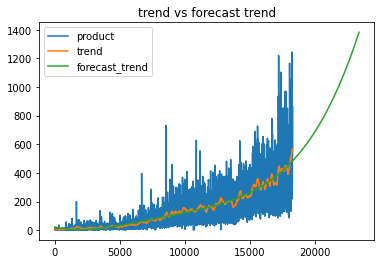

In [36]:
### plot the forecast trend ###
plt.figure()
plt.title('trend vs forecast trend')
df_reconstructed['product'].plot()
df_reconstructed['trend'].plot()
df_forecast['forecast_trend'].plot()
plt.legend()
plt.show()

# Seasonality Forecast

In [37]:
#forecasting seasonality
from sklearn.ensemble import RandomForestRegressor
def seas_forecasting(model_seas=RandomForestRegressor(n_estimators=100), N_forecast=N, period=168):
    model = make_pipeline(StandardScaler(), model_seas)
    y = df_reconstructed['seas']
    X = [[i%period] for i in range(len(y))]
    model.fit(X,y)
    X_pred = [[i%period] for i in range(len(y) + N_forecast)]
    y_pred = model.predict(X_pred)
    return y_pred

In [38]:
### get the seasonality from the forecasting function
y_pred = seas_forecasting()

df_forecast['forecast_seas'] = y_pred

In [39]:
###reconstruct a signal
df_forecast['forecast_values'] = df_forecast['forecast_trend']*df_forecast['forecast_seas']

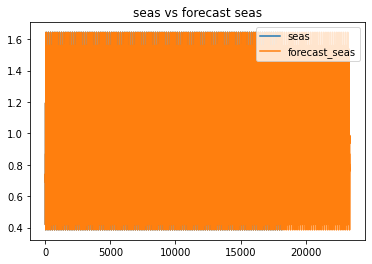

In [40]:
### plot the forecast seasonality ###
plt.figure()
plt.title('seas vs forecast seas')
df_reconstructed['seas'].plot()
df_forecast['forecast_seas'].plot()
plt.legend()
plt.show()

In [41]:
###increase the values where seasonality is hight 
for i in range(len(y_pred)):  #increase the highest values
    if df_forecast['forecast_seas'][i] > 1:
        df_forecast['forecast_values'][i] = df_forecast['forecast_values'][i]+91
    else:
        df_forecast['forecast_values'][i] = df_forecast['forecast_values'][i]+22


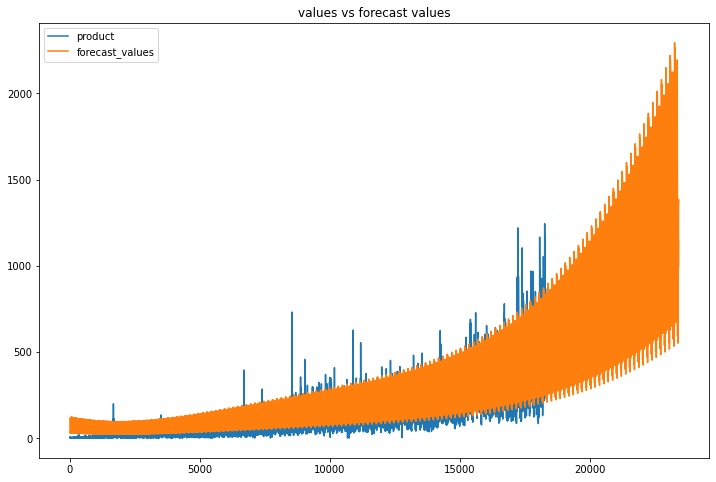

In [42]:
### plot the forecast without noise 
plt.figure(figsize=(12,8))
plt.title('values vs forecast values')
df_reconstructed['product'].plot()
df_forecast['forecast_values'].plot()
plt.legend()
plt.show()

In [43]:
submission['Count'] = list(df_forecast[-N:]['forecast_values'])
submission

,ID,Count
0,18288,692.319128
1,18289,487.111095
2,18290,410.931373
3,18291,340.340042
4,18292,284.978483
...,...,...
5107,23395,1384.915051
5108,23396,1367.358467
5109,23397,1316.141742
5110,23398,1372.025401


In [44]:
submission.to_csv('sub_test.csv', index=False)